In [1]:
import os
import numpy as np
from scipy.fft import ifftshift
import torch
import torch.nn as nn

from pickle import dump
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from joblib import Parallel, delayed
from tqdm import tqdm

from psygine.datasets.mri import Yang2021_Train, Yang2021_Valid, Yang2021_Test
from psygine.decoders.mri.net import ADMMCSNet

import matplotlib.pyplot as plt

torch.cuda.empty_cache()

2025-03-10 22:34:48.922799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741617288.945177    7821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741617288.951931    7821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 22:34:48.974657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


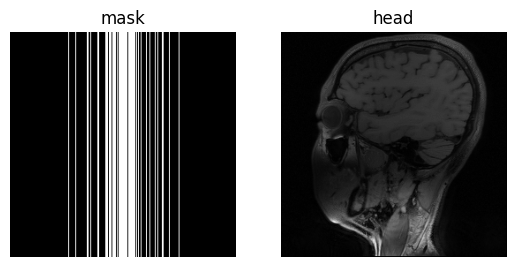

In [2]:
traindat = Yang2021_Train(local_path="/home/swolf/MyDisks/Cache1/DataBase")
valdat = Yang2021_Valid(local_path="/home/swolf/MyDisks/Cache1/DataBase")
testdat = Yang2021_Test(local_path='/home/swolf/MyDisks/Cache1/DataBase')

train, label = traindat[0]
mask = np.abs(train) > 0


fig, axs = plt.subplots(1, 2)
axs[0].imshow(ifftshift(mask), cmap='gray')
axs[0].axis('off')
axs[0].title.set_text('mask')
axs[1].imshow(np.abs(label), cmap='gray')
axs[1].axis('off')
axs[1].title.set_text("head")

In [3]:
class PrefetchDataSet:
    def __init__(self, mask, dataset, prefetch=False):
        self.mask = mask
        self.dataset = dataset
        self.prefetch = prefetch
        self._data = None
        if self.prefetch:
            self._data = Parallel(n_jobs=-1)(delayed(self.dataset.__getitem__)(i) for i in range(len(self.dataset)))

    def __getitem__(self, idx):
        if self.prefetch:
            train = torch.fft.fft2(torch.tensor(self._data[idx][1], dtype=torch.complex64), norm='ortho') * self.mask
            label = torch.tensor(self._data[idx][1], dtype=torch.complex64)
            return train, label
        else:
            train = (
                torch.fft.fft2(
                    torch.tensor(self.dataset[idx][1], dtype=torch.complex64),
                    norm="ortho",
                )
                * self.mask
            )
            label = torch.tensor(self.dataset[idx][1], dtype=torch.complex64)
            return train, label

    def __len__(self):
        return len(self.dataset)

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 5 every 50 epochs"""
    lr = lr * (0.5 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def criterion(output, target):
    return torch.mean(torch.norm(output-target, 'fro', dim=(-2, -1)) / torch.norm(target, 'fro', dim=(-2, -1)))

In [4]:
trainDataset = PrefetchDataSet(mask, traindat, prefetch=True)
valDataset = PrefetchDataSet(mask, valdat, prefetch=True)
testDataset = PrefetchDataSet(mask, testdat, prefetch=True)

The current network uses too much memory on my GTX 1080 with only 8GB memory, even with 32 channels instead 128 the authors proposed.

The bottleneck is resize, sub, and lt operations. I should check PWL module and avoid using cat operation.

In [5]:
# torch.cuda.init()
# torch.cuda.empty_cache()

# device = torch.device("cuda:1")
# model = ADMMCSNet(mask, 32, 5, Ns=8).to(device=device)
# input_tensor = torch.randn(1, 1, 256, 256).to(device=device)

# with torch.profiler.profile(
#     activities=[
#         torch.profiler.ProfilerActivity.CPU,
#         torch.profiler.ProfilerActivity.CUDA,
#     ],
#     profile_memory=True,
#     record_shapes=True,
# ) as prof:
#     model(input_tensor)

# print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


# device = torch.device("cuda:1")
# torch.autograd.set_detect_anomaly(True)

# model = ADMMCSNet(mask, 32, 5, Ns=8).to(device=device)

# optimizer = torch.optim.Adam(model.parameters())

# # tell CUDA to start recording memory allocations
# torch.cuda.memory._record_memory_history(enabled="all")

# for i in range(3):
#     # for batch_idx, (batch_input, batch_label) in enumerate(tqdm(train_loader)):
#     # batch_input, batch_label = next(train_loader)

#     batch_input = torch.randn(1, 256, 256).to(device)
#     batch_label = torch.randn(1, 256, 256).to(device)
#     batch_input = batch_input.unsqueeze(1).to(device=device)
#     batch_label = batch_label.unsqueeze(1).to(device=device)
#     output = model(batch_input)
#     loss = criterion(output, batch_label)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

# # save a snapshot of the memory allocations
# s = torch.cuda.memory._snapshot()
# with open(f"snapshot.pickle", "wb") as f:
#     dump(s, f)

# # tell CUDA to stop recording memory allocations now
# torch.cuda.memory._record_memory_history(enabled=None)

In [6]:
epochs = 1000
batch_size = 1
lr = 2e-3

In [7]:
train_loader = DataLoader(
    trainDataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)
val_loader = DataLoader(
    valDataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True
)
test_loader = DataLoader(
    testDataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True
)

In [8]:
torch.cuda.init()
torch.cuda.empty_cache()

device = torch.device('cuda:1')

model = ADMMCSNet(mask, 128, 5, Ns=8).to(device=device)

optimizer = torch.optim.Adam(model.parameters())

writer = SummaryWriter()
os.makedirs('models', exist_ok=True)

for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch, lr)

    # training
    training_loss = 0.0
    training_batches = 0
    pbar = tqdm(train_loader)
    for batch_idx, (batch_input, batch_label) in enumerate(pbar):
        batch_input = batch_input.unsqueeze(1).to(device=device)
        batch_label = batch_label.unsqueeze(1).to(device=device)
        output = model(batch_input)
        loss = criterion(output, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss += loss.cpu().detach().item()
        training_batches += 1
        pbar.set_postfix({"NRMSE": loss.cpu().detach().item()})

    training_loss /= training_batches
    writer.add_scalar("train loss", training_loss, epoch)

    if epoch % 10 == 0:
        torch.save(model.state_dict(), os.path.join('models', f'ck_{epoch}.pth'))

    model.eval()
    pbar = tqdm(val_loader)
    validate_loss = 0.0
    validate_batches = 0
    with torch.no_grad():
        for batch_idx, (batch_input, batch_label) in enumerate(pbar):
            batch_input = batch_input.unsqueeze(1).to(device=device)
            batch_label = batch_label.unsqueeze(1).to(device=device)

            output = model(batch_input)
            loss = criterion(output, batch_label)

            validate_loss += loss.cpu().detach().item()
            validate_batches += 1
            pbar.set_postfix({"NRMSE": loss.cpu().detach().item()})

        if epoch % 10 == 0:
            recon_image = make_grid(
                torch.cat([
                    torch.abs(output.detach().cpu().squeeze()),
                    torch.abs(batch_label.detach().cpu().squeeze()),
                ], dim=0),
                nrow=1, normalize=True, scale_each=True
            )
            writer.add_image('recon image', recon_image, epoch)

    validate_loss /= validate_batches
    writer.add_scalar("valid loss", validate_loss, epoch)

writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 1 has a total capacity of 7.92 GiB of which 39.50 MiB is free. Including non-PyTorch memory, this process has 7.87 GiB memory in use. Of the allocated memory 7.75 GiB is allocated by PyTorch, and 1.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)